In [2]:
import random
class Bandit:
    '''スロットマシン  確率 p で  1, 1-p で 0 を返す （ベルヌーイ分布）
         インスタンス変数：p   ランダムに [0, 1] の値が設定されている。
         メソッド：
            slot() スロットを引く。確率 p で  1, 1-p で 0 が返ってくる。
    '''
    def __init__(self):
        self.p = random.uniform(0,1)

    def slot(self):
        if (random.uniform(0,1) <  self.p):
            return 1
        else:
            return 0

    def update(self):
        '''1/2 の確率で，0.05 上げるか下げるか。 今は使用しない。\
        0 または 1 になったらそれ以上は動かさない。'''
        if(random.uniform(0,1) < 0.5):
            self.p = max(self.p - 0.05, 0)
        else:
            self.p = min(self.p + 0.05, 1)

class MultiArmedBandit:
    '''スロットマシンを10個まとめたもの
         クラス変数：NUM  10 (定数)
         インスタンス変数：bandits スロットマシンのリスト
         メソッド：
            slot(i) i 番目のスロットを引く。
            getmax() スロットマシンの確率の最大値を返す。
    '''
    NUM= 10;   #スロットマシンの個数
    def __init__(self):
        self.bandits = [Bandit() for i in range(MultiArmedBandit.NUM)]

    def slot(self,i):
        '''i 番目のスロットマシンを引く'''
        if (i < 0 or i >= MultiArmedBandit.NUM):
            return 0
        return self.bandits[i].slot()

    def update(self):
        '''全ての確率を更新。今は使用しない。'''
        for b in self.bandits:
            b.update()

    def getmax(self):
        return max([x.p for x in self.bandits])

In [3]:
#1
class RandomStrategy:
    ''' ランダムにスロットマシンを引く戦略
    '''
    def learn(self,k, result):
        return

    def choice(self):
        return random.randrange(MultiArmedBandit.NUM);

    def reset(self):
        return

In [4]:
#2
class TsuikiStrategy:
    ''' 前のが当たったらそれを引く戦略
    インスタンス変数:
        my : 次に引く手
    '''
    def __init__(self):
        self.my = 0
    def learn(self, k, result):
        if (result == 1):
            self.my = self.my;
        else:
            self.my = (self.my + 1)% MultiArmedBandit.NUM

    def choice(self):
        return self.my

    def reset(self):
        self.my = 0

In [5]:
#3
class FujitaStrategy:
    def __init__(self):
        self.my=0
        self.n=0
        self.ret=[0]*MultiArmedBandit.NUM
    def learn(self,k,result):
        if self.n<100:
            self.n+=1
            self.my=self.n%MultiArmedBandit.NUM
            self.ret[k]+=result
        else:
            if result==1:
                self.ret[k]+=1
                self.my=self.ret.index(max(self.ret))
            if result==0:
                self.ret[k]-=10
                self.my=self.ret.index(max(self.ret))
    def choice(self):
        return self.my
    def reset(self):
        self.my=0
        self.n=0
        self.ret=[0]*MultiArmedBandit.NUM


In [6]:
#4
class KamimuraChangeStrategy:
    NUM=10
    def __init__(self,nn=2,pp=0.5):
        self.n=nn
        self.lr=[1]*nn
        self.my=0
        self.i=0
        self.p=pp
    def learn(self,k,result):
        self.lr[self.i]=result
        self.i+=1
    def choice(self):
        if self.i==self.n: 
            if sum(self.lr)<self.n*self.p:
                self.my=(self.my+1)%KamimuraChangeStrategy.NUM
            self.i=0
            return self.my
        else:
            return self.my
    def reset(self):
        self.lr=[1]*self.n
        self.my=0
        self.i=0

In [7]:
#5
class KanouStrategy:
    
    def __init__(self):
        '''引数
        　　my:　　次に引く手
            count:今まで何回引いたか
            to:　　[0,0]を引いた時のカウント
            a:　   ここ2回の結果'''
        self.my = 0
        self.count = 0
        self.to = [-1000]*MultiArmedBandit.NUM
        self.a = [1,1]
        self.b = 0
        
    def learn(self, k, result):
        #print (result)
        if ((self.count)%2 == 1):
            self.my = self.my
            self.a[0] = result
        else:
            self.a[1] = result
            self.b = 0
            if (self.a == [0,0]):
                self.to[self.my] = self.count
                self.my = (self.my + 1)% MultiArmedBandit.NUM
            elif (self.a == [1,1]):
                self.my = self.my
            else:
                self.my = (self.my + 1)% MultiArmedBandit.NUM
            while ((self.to[self.my] + 100) > self.count):
                self.my = (self.my + 1)% MultiArmedBandit.NUM
                self.b += 1
                #print (self.my)
                if (self.b == 10):
                    break
            #print (self.count)
            #print (self.a)
            #print(self.to)
            
        
        
    def choice(self):
        #print ("a")
        #print (self.my)
        
        self.count += 1
        return self.my

    def reset(self):
        self.my = 0
        self.count = 0
        self.to = [-1000]*MultiArmedBandit.NUM
        self.a = [1,1]
        self.b = 0

In [8]:
#6
class MikamiStrategy:
    ''' 前のが当たったらそれを引き、若し外れても10回連続で当たりが出ていればそのまま引き続ける
        更に、どのスロットでも引き続けないときは確率が高そうなスロットにする戦略
    インスタンス変数:
        my : 次に引く手
        hit_len : 当たりの連続回数
        count_slot_hit : 各スロットの当たりの回数
        count_slot : 各スロットを引いた回数        
    '''
    def __init__(self):
        self.my = 0
        self.hit_len = 0
        self.count_slot_hit = [0]*10
        self.count_slot = [0]*10
    def learn(self, k, result):
        if (result == 1):
            self.my = self.my
            self.hit_len += 1
            self.count_slot_hit[self.my] += 1
            self.count_slot[self.my] += 1
        elif ((self.count_slot[self.my]>500 and self.count_slot_hit[self.my]/self.count_slot[self.my] > 0.9)
            or
             (self.count_slot[self.my]>1000 and self.count_slot_hit[self.my]/self.count_slot[self.my] > 0.8)):
            self.my = self.my
            self.count_slot[self.my] += 1
            if (result == 1):
                self.hit_len += 1
                self.count_slot_hit[self.my] += 1
            else:
                self.hit_len = 0
        elif (result == 0 and self.hit_len > 10):
            self.my = self.my
            self.hit_len = 0
            self.count_slot[self.my] += 1
        else:
            self.my = (self.my + 1)% MultiArmedBandit.NUM
            self.hit_len = 0
            self.count_slot[self.my] += 1
    def choice(self):
        return self.my

    def reset(self):
        self.my = 0
        self.hit_len = 0
        self.count_slot_hit = [0]*10
        self.count_slot = [0]*10

In [9]:
#7
class MurataStrategy:
    
    def __init__(self):
        self.my = 0
        self.times = 0
        self.kiroku = 0
        
    def learn(self, k, result):
        self.kiroku += result
        self.times += 1
        if (self.times == 10):
            self.times = 0
            if (self.kiroku < 7):
                self.my = (self.my + 1)% MultiArmedBandit.NUM
            self.kiroku = 0
        

    def choice(self):
        return self.my

    def reset(self):
        self.my = 0

In [10]:
#8
class NagamotoStrategy:
    import random
   
    def __init__(self):
        self.my = random.randrange(MultiArmedBandit.NUM)
        
    
    def learn(self, k, result): 
        g = list(range(10)) ; g1 = g[:4] ; g2 = g[4:7] ; g3 = g[7:10]
        
        if (result == 1):
            self.my = self.my
        
        elif (result == 0):
            if (self.my in g1 ):
                self.my = random.choice(g2)
            elif (self.my in g2 ):
                self.my = random.choice(g3)
            elif (self.my in g3 ):
                self.my = random.choice(g1)
                
        
    def choice(self):
        return self.my
        
        
    def reset(self):
        self.my = random.randrange(MultiArmedBandit.NUM)   

In [11]:
#9
class NagaoChangeStrategy:
    def __init__(self):
        NagaoChangeStrategy.storek = 0
        #storek...試行回数
        NagaoChangeStrategy.storer = [0]*10
        #storer[k]...kが1だった回数
    def learn(self, k, result):
        NagaoChangeStrategy.storek += 1
        if (result == 1):
            NagaoChangeStrategy.storer[k] += 1
    def choice(self):
        if NagaoChangeStrategy.storek <= 100:
            return random.randrange(MultiArmedBandit.NUM)
        return NagaoChangeStrategy.storer.index(max(NagaoChangeStrategy.storer))
    def reset(self):
        if NagaoChangeStrategy.storek > 200:
            NagaoChangeStrategy.storek = 0
            NagaoChangeStrategy.storer = [0]*10    
        return

In [12]:
#10
class nojimaStrategy:
    def __init__(self):
        self.my = 0
        self.hits = [0] * 10
        self.counter = 0
        self.top4 = [0] * 4
    def learn(self, k, result):
        self.counter += 1
        if (result == 1):
            self.hits[k] += 1
        if(self.counter >= 500):
            self.my = self.hits.index(max(self.hits))
        else:
            self.my = self.my
    def choice(self):
        if(self.counter < 500):
            return self.counter % 10
        elif(self.counter == 500):
            lista = np.array(self.hits)
            self.top4 = lista.argsort()[-4:]
            return self.top4[0]
        elif(self.counter < 900):
            a = self.counter % 4
            return self.top4[a]
        else:
            return self.hits.index(max(self.hits))
    def reset(self):
        self.my = 0
        self.hits = [0]*10
        self.counter = 0
        self.top4 = [0] * 4

In [13]:
#11
class OhmuraStrategy:
    def __init__(self):
        self.count = 10 *[0]
        self.times = 0
        self.thr = 650

    @classmethod
    def init_with_thr(cls, threshold):
        tmp = cls()
        tmp.thr = threshold
        return tmp

    def learn(self, k, result):
        if(self.times <= self.thr):
            self.count[k] = self.count[k] + result
            self.times += 1
        else:
            pass

    def choice(self):
        if (self.times < self.thr):
            return random.randrange(MultiArmedBandit.NUM)
        if(self.times == self.thr):
            self.max = self.count.index(max(self.count))
            return self.max
        else:
            return self.max

    def reset(self):
        self.count = 10 * [0]
        self.times = 0
        self.max = 0

    def update_thr(self, threshold):
        self.thr = threshold

In [14]:
#12
class OkuboStrategy:
    def __init__(self):
        self.th = 0
        self.lis = [0]*MultiArmedBandit.NUM
        self.ma = 0
        self.co = 0
        self.cou = 0
    def learn(self,k, result):
        if result == 1:
            self.lis[k] += 1
            self.th += 1
        else:
            self.th += 1
        if self.th > 101:
            if result == 1:
                self.co += 1
                self.cou += 1
            else:
                self.cou += 1
            if self.cou == 10:
                self.lis[self.ma] = self.co/self.cou
                (self.co,self.cou) = (0,0)
                a = max(self.lis)
                self.ma = self.lis.index(a)
    def choice(self):
        if self.th <= 100:
            return self.th % 10
        elif self.th == 101:
            a = max(self.lis)
            self.ma = self.lis.index(a)
            return self.ma
        elif self.th > 101:
            return self.ma
    def reset(self):
        self.th = 0
        self.lis = [0]*MultiArmedBandit.NUM
        self.ma = 0


In [15]:
#13
class TanakaStrategy:
    ''' 
        前のが当たったらそれを引く戦略をベースとし、
    　　過去10回分のデータで期待値が高い台があればそれを選択する
    '''
    def __init__(self):
        self.x=0 #試行の通し番号
        self.y=0 # 前のが当たったらそれを引く戦略用
        self.a=[] #各台の当りの出た回数を記録
        self.b=[]
        for i in range(10):
            self.a.append([0])
            self.b.append(0)
        self.my = 0  #次に引く手
    def learn(self, k, result):
        self.x+=1 #試行回数を1増やす
        if(len(self.a[k-1])>5):#過去5回分のデータを残す
            self.a[k-1].pop(0)#最も古いデータを削除
        if (result == 1):#当りだったら
            self.y = self.my;
            self.a[k-1].append(1) #記録しておく
        elif(result == 0):#外れなら
            self.y = (self.my + 1)% MultiArmedBandit.NUM
            self.a[k-1].append(0) #記録しておく

    def choice(self):
        if(self.x>100):#100回目以降の操作
            b = [sum(self.a[i])/len(self.a[i]) for i in range(10)]#平均値のリストを作成
            c = [self.b[j] for j in range(10) if self.b[j]>0.89]#平均値0.89以上の台をリストアップ
            if(len(c)>0):#存在するなら
                self.my=self.b.index(max(self.b))#最大値の台番号を取得
            else:#存在しないなら
                self.my=self.y # 前のが当たったらそれを引く戦略
        else:#100回目までは、前のが当たったらそれを引く戦略
            self.my=self.y #myを再更新
        return self.my

    def reset(self):
        self.x=0 #試行の通し番号
        self.y=0 #前のが当たったらそれを引く戦略用
        self.a=[] #各台の当りの出た回数を記録
        self.b=[]
        for i in range(10):
            self.a.append([0])
            self.b.append(0)
        self.my = 0  #次に引く手

In [16]:
#14
class SekiguchiStrategy:

    def __init__(self):
        self.my = 0 #引くスロット
        self.drawcount = 0 #引いた回数
        self.hitcount = dict() #スロットごとのあたり回数（辞書）
        for i in range(MultiArmedBandit.NUM):
            self.hitcount[i] = 0
        self.pmax = 0 #最も確率の高いスロットの確率
        self.mymax = 0 #最も確率の高いスロット
        self.l = [0]*MultiArmedBandit.NUM #各スロットの確率
        self.acount = dict() #スロットごとの引いた回数（辞書）
        for i in range(MultiArmedBandit.NUM):
            self.acount[i] = 0
        self.num = dict() #各スロットとその確率
        self.a = 100
        
            
        
    def learn(self,k, result):
        self.acount[k] += 1
        if (result == 1):
            self.hitcount[k] +=1       


    def choice(self):
        self.drawcount +=1
        if (self.drawcount <= self.a*MultiArmedBandit.NUM):
            for i in range(MultiArmedBandit.NUM):
                if (self.drawcount <= self.a*(i+1)):
                    self.my = i
                    return self.my 
                else:
                    continue

        else:
            for i in range(MultiArmedBandit.NUM):
                self.l[i] = self.hitcount[i]/(self.a + self.acount[i])
                self.num[i] = self.l[i]
                if (self.l[i] > self.pmax):
                    self.pmax = self.l[i]
                    self.mymax = i
            if (random.uniform(0,1) <= self.pmax):
                self.my = self.mymax
            else:
                self.ll = self.l.copy()
                for k,v in self.num.items():
                    if sorted(self.ll)[-2] == v:
                        self.my = k
            return self.my

    def reset(self):
        self.drawcount = 0 #引いた回数
        self.hitcount = dict() #スロットごとのあたり回数（辞書）
        for i in range(MultiArmedBandit.NUM):
            self.hitcount[i] = 0
        self.pmax = 0 #最も確率の高いスロットの確率
        self.mymax = 0 #最も確率の高いスロット
        self.l = [0]*MultiArmedBandit.NUM #各スロットの確率
        self.acount = dict() #スロットごとの引いた回数（辞書）
        for i in range(MultiArmedBandit.NUM):
            self.acount[i] = 0
        self.num = dict() #各スロットとその確率
        self.my = 0

In [17]:
#15
import numpy as np

#自分の戦略
class IzumiStrategy:
    
    #過去の学習データをリストとして保持（忘却する際に参照するため）し、時間経過も把握。
    def __init__(self):
        self.distributions=[self.beta() for i in range(MultiArmedBandit.NUM)]
        self.my=0
        
        self.time=0      
        self.past_slot=[]
        self.past_result=[]


    #以下ベータ分布を扱うクラスは同じ
    class beta:
        
        def __init__(self):
            self.a=1
            self.b=1
            
        def sammpling(self):
            return np.random.beta(self.a,self.b)      
       
        def update(self,result):
            if result==1:
                self.a+=1
            else:
                self.b+=1
    
    
    #スロットの確率は変化しているので、遠すぎる過去の学習データを忘れる機能を追加
    def forget(self,t):
        slot=self.past_slot[t]
        result=self.past_result[t]
        if result==1:
            self.distributions[slot].a+=-1
        else:
            self.distributions[slot].b+=-1
    
    #学習の際、スロットの分布のパラメータを更新すると同時に、十分な時間（effective_memoryで定義）が経っていれば過去データを忘却
    def learn(self,k,result):
        effective_memory=150
        
        self.time+=1
        self.past_slot.append(k)
        self.past_result.append(result)  
        
        if self.time>=effective_memory:
            self.forget(self.time-effective_memory)
            
        self.distributions[k].update(result)

    #以下同じ
    def choice(self):
        sample=[]
        for i in self.distributions:
            sample.append(i.sammpling())
        self.my=sample.index(max(sample))   
        
        return self.my
        
    def reset(self):
        self.my=0

In [18]:
#16
import math
'''Xj + c sqrt(2 log n / nj)  for c = 100'''

class UcbStrategy:
    def __init__(self,cc = 0.16):
        self.totalnum = 1
        self.expectedValues = [0]*MultiArmedBandit.NUM
        self.numtosses = [0]*MultiArmedBandit.NUM
        self.c = cc;  #c == 14 is the best in my experiment!!, 
                        #with the average 0.869

    def learn(self,i, result):
        self.totalnum += 1
        self.numtosses[i] += 1;
        if (result == 1):
            self.expectedValues[i] += 1;

    def choice(self):
        ind = 0;
        maxv = 0;
        for i in range(MultiArmedBandit.NUM):
            k =self.expectedValues[i]/(self.numtosses[i]+0.01) + \
            self.c * math.sqrt(2 * math.log(self.totalnum) / (self.numtosses[i]+0.01))
            if (k > maxv):
                maxv = k
                ind = i
        return ind;

    def reset(self):
        self.totalnum = 1;
        self.expectedValues = [0] * MultiArmedBandit.NUM
        self.numtosses = [0] * MultiArmedBandit.NUM

In [19]:
#17
class ThompsonStrategy:
    def __init__(self):
        self.total = [0]*10
        self.atari = [0]*10
        
    def learn(self, k, result):
        self.total[k] += 1
        self.atari[k] += result        

    def choice(self):
        betas = [np.random.beta(self.atari[k]+1,self.total[k]-self.atari[k]+1) for k in range(10)]
        return betas.index(max(betas))

    def reset(self):
        self.total = [0]*10
        self.atari = [0]*10    

In [20]:
#18
import math

class TAStrategy: #1試行約0.2s

    def __init__(self):
        self.my = 0
        self.total = [0]*10
        self.atari = [0]*10
        self.death = []
        self.prob = 1
    
    def probability(self,n,i,p): #確率pのものをn回引いて丁度i回当たる確率
        prob = (math.factorial(n) // (math.factorial(i) * math.factorial(n-i))) * (p**i)* ((1-p)**(n-i))
        return prob
    
    def probability_sum(self,n,m,p): #確率pのものをn回引いてm回以下しか当たらない確率
        prob=0
        if n<=100:
            for i in range(m+1):
                prob += self.probability(n,i,p)
            return prob
        if n>100:  #n>250の場合は計算しない
            return 1
        
    def check(self,n,k,p):
        if n<=100:
            tf = self.probability_sum(n,k,p) < 0.05  #確率をpと仮定する。pなのにn回してk回以下しか当たらないという確率は5%しかない
        if n>100:
            tf = k-n*p < -2.33*((n*p*(1-p))**0.5) #1%で棄却
        return tf
    
    def learn(self, k, result):
        self.total[k] += 1
        self.atari[k] += result
        if self.check(self.total[k],self.atari[k],self.prob) == True:
            self.death.append(k)
            while len(self.death)==10: #全てdeathになったら
                self.death.clear()     #deathを空にして
                self.prob = self.prob-0.005   #棄却基準の見直し
                for k in range(10):    #棄却判定の見直しを行う
                    if self.check(self.total[k],self.atari[k],self.prob) == True: 
                        self.death.append(k)
        self.my =(self.my+1) % MultiArmedBandit.NUM
        while ((self.my) % MultiArmedBandit.NUM) in self.death:
            self.my = (self.my+1)% MultiArmedBandit.NUM
            
    def choice(self):
        return self.my

    def reset(self):
        self.my = 0
        self.total = [0]*10
        self.atari = [0]*10
        self.death = []
        self.prob = 1

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def MABTest(numplay, strategy, mab, change=False):
    '''引数：
    　　numplay : 回数
      　strategy : ストラテジー
        mab :  MultiArmedBandit
    
    mab から strategy に従って numplay 回引いて当たった回数をグラフ表示する'''
    total = [0]*10
    atari = [0]*10
    myaccount = 0
    for i in range(numplay):
        k = strategy.choice();   # strategy に聞いて
        result = mab.slot(k);   # 言われたスロットをひいて
        total[k] += 1
        atari[k] += result
        myaccount += result;    # 結果だけ account を増やす (0 か 1)
        strategy.learn(k,result);     #k を引いて結果が result だったことを str に学習させる
        if(change):
            mab.update()   # 確率を毎回変化させるには，change を true にする。
    print(f"{numplay} 中 {myaccount}回あたり")   

    fig, ax1 = plt.subplots()
# この行は，次の2行と同じ。
#    fig = plt.figure()
#    ax1 = fig.add_subplot(1,1,1)
 
    ax1.plot([x.p for x in mab.bandits], color="red", label="スロット確率")
    ax1.set_ylim(0,1)
    ax2 = ax1.twinx()  # 右目盛りと左目盛り
    ax2.plot(atari, label="当たり回数")
    ax2.plot(total, label="引いた回数")
    ax2.set_ylim(0,10000)
    ax1.legend(loc='upper left', prop={"family":"MS Gothic"}) 
    ax2.legend(loc='upper right', prop={"family":"MS Gothic"})  
#        print([f"{x.p:2.2}" for x in m.bandits])
#    print([f"{atari[x]:4}" for x in range(10)])
#    print([f"{total[x]:4}" for x in range(10)])

10000 中 9871回あたり


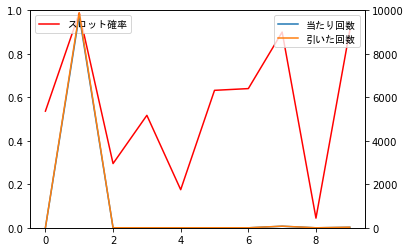

In [22]:
for i in range(1):
    MABTest(10000, TAStrategy(), MultiArmedBandit()) 

In [23]:
import numpy as np

def OnePlay(numplay, strategies, mab, change=False):
    ''' strategies : 戦略のリスト
    結果は，それぞれの戦略での当たり確率を，ndarray として返す。'''
    myaccounts = np.zeros(len(strategies), dtype=int)
    for x in strategies:
        x.reset()

    for i in range(numplay):
        for s in range(len(strategies)):
            k = strategies[s].choice() 
            result = mab.slot(k)   
            myaccounts[s] += result 
            strategies[s].learn(k,result)  
        if(change):
            mab.update()  # 確率が変化していく場合
    return(myaccounts/numplay)  

def MultiMABTester(n, strategies, change=False):
    NUMPLAY = 10000
    ret = np.zeros((len(strategies),0))
    print(ret.shape)
    
    for i  in range(n):
        mab = MultiArmedBandit()
        ret = np.append(ret, OnePlay(NUMPLAY, strategies, mab, change).reshape(len(strategies),1), axis=1)
    return ret

(18, 0)


[(0.7823449999999998, 'Fujita'),
 (0.7688600000000001, 'Kamimura'),
 (0.7530650000000001, 'Mikami'),
 (0.7387899999999998, 'Kanou'),
 (0.736775, 'Tanaka'),
 (0.733915, 'Tsuiki'),
 (0.728645, 'Izumi'),
 (0.724315, 'Nagamoto'),
 (0.70387, 'Murata'),
 (0.630895, 'Ucb'),
 (0.6266400000000001, 'TA'),
 (0.5910250000000001, 'Thompson'),
 (0.5367949999999999, 'Okubo'),
 (0.5131549999999999, 'Nagao'),
 (0.504005, 'nojima'),
 (0.501725, 'Random'),
 (0.50025, 'Ohmura'),
 (0.4930200000000001, 'Sekiguchi')]

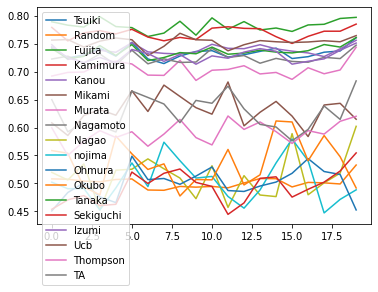

In [24]:
names = ["Tsuiki", "Random","Fujita","Kamimura","Kanou","Mikami","Murata","Nagamoto","Nagao","nojima","Ohmura","Okubo","Tanaka","Sekiguchi","Izumi","Ucb","Thompson","TA"]
numplay=20
ret = MultiMABTester(numplay, [TsuikiStrategy(),
                               RandomStrategy(),
                               FujitaStrategy(),
                               KamimuraChangeStrategy(),
                               KanouStrategy(),
                               MikamiStrategy(),
                               MurataStrategy(),
                               NagamotoStrategy(),
                               NagaoChangeStrategy(),
                               nojimaStrategy(),
                               OhmuraStrategy(),
                               OkuboStrategy(),
                               TanakaStrategy(),
                               SekiguchiStrategy(),
                               IzumiStrategy(),
                               UcbStrategy(),
                               ThompsonStrategy(),
                               TAStrategy()], change=True)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
for i in range(len(names)):
    ax1.plot(ret[i], label=names[i])
ax1.legend(loc='upper left')
sorted(zip(map(lambda x: sum(x)/numplay,ret), names), reverse=True)